# Measures of Risk

In [236]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [237]:
warnings.filterwarnings('ignore')

## Standard Deviation

Measures the tremors in an investment's performance, helping anticipate earthquakes in portfolios or assets.

In [63]:
tickers = ["AAPL", "GOOG", "AMZN", "MSFT"]

AAPL = yf.download('AAPL', start='2020-01-01')
GOOG = yf.download('GOOG', start='2020-01-01')
AMZN = yf.download('AMZN', start='2020-01-01')
MSFT = yf.download('MSFT', start='2020-01-01')

tech_list = [AAPL, GOOG, AMZN, MSFT]

for stock in tech_list:
    stock["Date"] = stock.index.date

for stock in tech_list:
    stock.set_index("Date", drop=True, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [65]:
for i, stock in enumerate(tech_list):
  stock['Daily Return'] = stock['Close'].pct_change()
  std_dev = stock['Daily Return'].std()
  print(f"The standard deviation of {tickers[i]} daily returns is: {std_dev}")

The standard deviation of AAPL daily returns is: 0.019876209630829426
The standard deviation of GOOG daily returns is: 0.020410964202964926
The standard deviation of AMZN daily returns is: 0.02246108249105194
The standard deviation of MSFT daily returns is: 0.019085214500157866


## Sharpe Ratio

The Sharpe ratio enables investors to assess how much excess return they're receiving for the extra volatility of holding a specific asset. A higher Sharpe ratio indicates better risk-adjusted performance.

In [46]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - (risk_free_rate / 252)
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)
    return sharpe_ratio

for i, stock in enumerate(tech_list):
  sharpe_ratio = calculate_sharpe_ratio(stock['Daily Return'])
  print(f"The Sharpe Ratio for {tickers[i]} is: {sharpe_ratio:.4f}")

The Sharpe Ratio for AAPL is: 0.8374
The Sharpe Ratio for GOOG is: 0.6627
The Sharpe Ratio for AMZN is: 0.5566
The Sharpe Ratio for MSFT is: 0.7282


## Beta

Beta measures a security or sector's systematic risk relative to the entire stock market. It provides investors a quick way to assess an investment's volatility compared with a benchmark, typically the broader market.

In [45]:
for i, stock in enumerate(tech_list):
  beta = yf.Ticker(tickers[i]).info.get('beta')
  print(f"The beta of {tickers[i]} is: {beta}")

The beta of AAPL is: 1.178
The beta of GOOG is: 1.025
The beta of AMZN is: 1.192
The beta of MSFT is: 0.914


## Value at Risk (VaR)

Value at Risk (VaR) is a statistical measure of the potential loss in value of a risky asset or portfolio in a given period for a given confidence interval. It provides a single, easy-to-understand number that encapsulates the downside risk of an investment.

 VaR can be calculated using several methods:

* The historical method uses past data to project future outcomes.
* The variance-covariance method (or parametric method) assumes a normal distribution of returns.
* Monte Carlo simulations generate many scenarios based on the criteria provided

### Monte Carlo simulations for calculating VaR

In [47]:
def stock_monte_carlo(start_price, days, mu, sigma, dt):
  price = np.zeros(days)
  price[0] = start_price

  shock = np.zeros(days)
  drift = np.zeros(days)

  for x in range(1, days):
    drift_delta = mu * dt

    shock[x] = np.random.normal(loc=drift_delta, scale=sigma * np.sqrt(dt))
    drift[x] = drift_delta
    price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))

  return price

<ipython-input-47-a7b9ebeed527>:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price[0] = start_price
<ipython-input-72-394abf53c347>:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend()


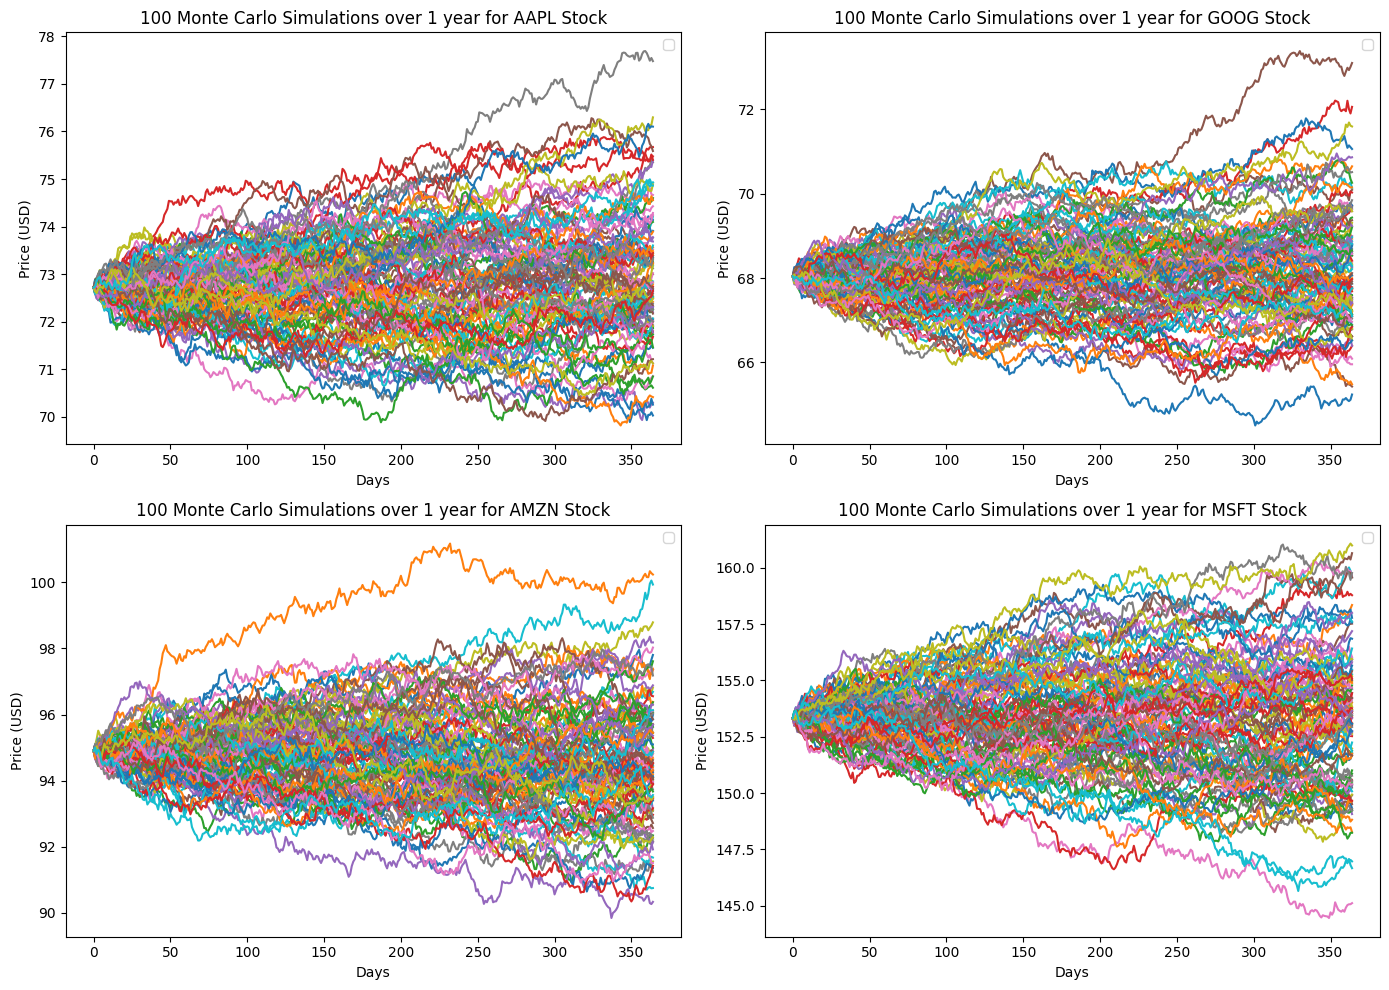

In [72]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

days = 365
dt = 1/days

for i, stock in enumerate(tech_list):
  start_price = stock["Close"].iloc[0]
  mu = stock["Daily Return"].mean()
  sigma = stock["Daily Return"].std()

  for run in range(100):
    axs[i].plot(stock_monte_carlo(start_price,days,mu,sigma,dt))

  axs[i].set_title(f'100 Monte Carlo Simulations over 1 year for {tickers[i]} Stock')
  axs[i].set_xlabel('Days')
  axs[i].set_ylabel('Price (USD)')
  axs[i].legend()

plt.tight_layout()
plt.show()

In [89]:
runs = 10000
simulations = np.zeros(runs)
simulation_df = pd.DataFrame()

np.set_printoptions(threshold=5)

for i, stock in enumerate(tech_list):
  start_price = stock["Close"].iloc[0]
  mu = stock["Daily Return"].mean()
  sigma = stock["Daily Return"].std()

  for run in range(runs):
      simulations[run] = stock_monte_carlo(start_price,days,mu,sigma,dt)[days-1]

  temp_df = pd.DataFrame({
      'Ticker': [tickers[i]] * runs,
      'Simulation': simulations
  })

  simulation_df = pd.concat([simulation_df, temp_df], ignore_index=True)

<ipython-input-47-a7b9ebeed527>:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price[0] = start_price


Creating 10000 Monte Carlo simlulations for AAPL
For every initial purchase of an AAPL stock, you're putting about $3.12 at risk 99% of the time
Creating 10000 Monte Carlo simlulations for GOOG
For every initial purchase of an GOOG stock, you're putting about $3.06 at risk 99% of the time
Creating 10000 Monte Carlo simlulations for AMZN
For every initial purchase of an AMZN stock, you're putting about $4.66 at risk 99% of the time
Creating 10000 Monte Carlo simlulations for MSFT
For every initial purchase of an MSFT stock, you're putting about $6.37 at risk 99% of the time


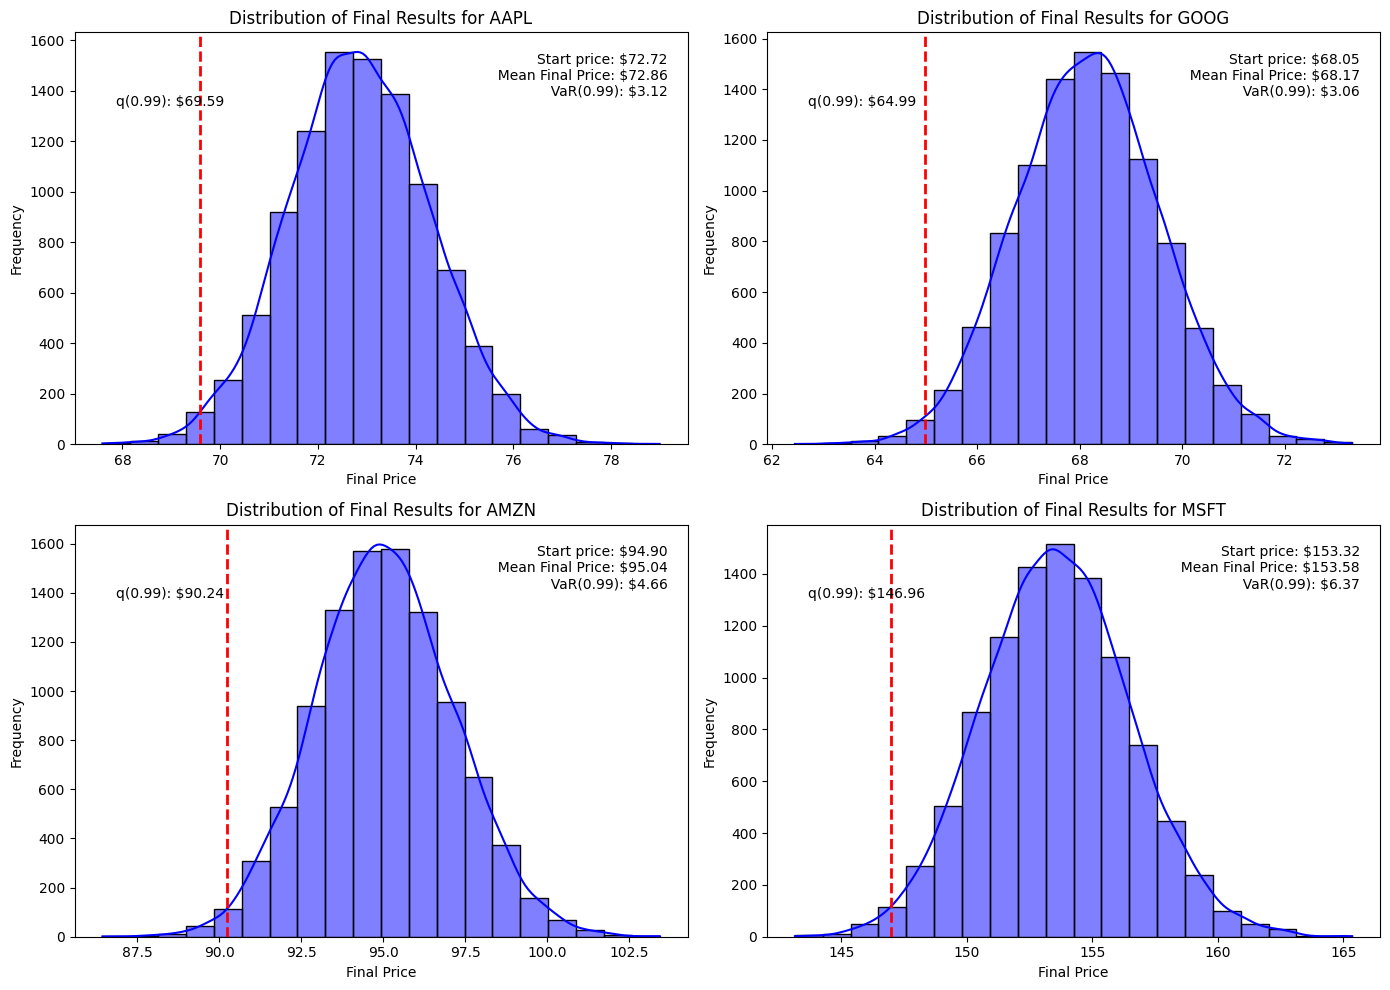

In [242]:
runs = 10000
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, stock in enumerate(tech_list):
  print("Creating {} Monte Carlo simlulations for {}".format(runs, tickers[i]))

  ax = axs[i // 2, i % 2]
  simulations = simulations = np.zeros(runs)

  start_price = stock["Close"].iloc[0]
  mu = stock["Daily Return"].mean()
  sigma = stock["Daily Return"].std()

  for run in range(runs):
      simulations[run] = stock_monte_carlo(start_price,days,mu,sigma,dt)[days-1]

  q = np.percentile(simulations, 1)
  print(
      "For every initial purchase of an {} stock, " \
      "you're putting about ${:.2f} at risk 99% of the time"
      .format(tickers[i], start_price[0] - q)
  )

  sns.histplot(
      data=simulations,
      bins=20,
      color='blue',
      kde=True,
      edgecolor='black',
      ax=ax
  )

  ax.set_title(f'Distribution of Final Results for {tickers[i]}')
  ax.set_xlabel('Final Price')
  ax.set_ylabel('Frequency')

  annotation = """Start price: ${:.2f}
  Mean Final Price: ${:.2f}
  VaR(0.99): ${:.2f}
  """.format(
      start_price[0],
      simulations.mean(),
      start_price[0] - q
  )

  ax.annotate(
    annotation,
    xy=(1,.75),
    xycoords='axes fraction',
    xytext=(-20,20),
    textcoords='offset pixels',
    horizontalalignment='right',
    verticalalignment='bottom'
  )
  ax.annotate(
    'q(0.99): ${:.2f}'.format(q),
    xy=(.1,.8),
    xycoords='axes fraction',
    xytext=(-20,20),
    textcoords='offset pixels',
    horizontalalignment='left',
    verticalalignment='top'
  )

  ax.axvline(
      q,
      color='red',
      linestyle='dashed',
      linewidth=2
  )

plt.tight_layout()
plt.show()